

# Introduction
We propose a novel architecture, SINONE, for implicit representations, which performs at the same level and has similar convergence to the Fourier Features proposed in (Tancik et al., 2020), but doesn't require any preprocessing of the data! Specifically, we propose a model whose first layer's activation is sin, which is initialized with a uniform distribution, and with a scale hyperparameter that behaves very similarly to the scale parameter in the aforementioned paper. In this document, we will delve into two very promising directions of implicit representations in computer vision from (Tancik et al., 2020) and (Sitzmann et al., 2020). Specifically, we will investigate a close relative to SIREN networks from the lens of the Neural Tangent Kernel (NTK) (Jacot et al. 2019), especially the suggested uniform initialization scheme and scale hyperparameter w_0 in the first layer of the network, i.e., the output of the first layer of a SIREN is sin(w_0 * Wx + b) where w_0 is a scalar. We note that SIREN networks can memorize things (like images) well, but may not perform as well in tasks which require generalization. Here, we find that SINONE achieves better performance in generalization in image regression, while exhibiting very similar convergence properties to ReLU MLPs with Fourier Features when varying the scale parameter.

# Investigating architectures
In this section, we investigate multiple architectures for our analysis. First, we find the novel empirical result that networks with periodic activations can outperform or perform on par with the positional encoding proposed in (Tancik et al., 2020) and (Mildenhall et al. 2020) not only in memorization, but also in image regression, given a suitable initialization scheme. Instead of working directly with networks with only sin activations as in SIREN, we propose a novel network, SINONE, whose first layer has a sin activation. To justify this choice, we conduct some simple experiments on image regression, noting that the chosen architecture is much more numerically stable in analysis by the Neural Tangents library (Novak et al. 2020). We choose to perform the experiments on a picture of a fish with reesolution 512 by 1024. We choose this picture because of the memory-intensive requirements of calculating the NTK, which makes the subgrid of pixels corresponding to training data small, for which we compensate by a picture which doesn't have such fine pixel-wise details. We choose to select every 64th pixel in the image and try to reconstruct the rest of the pixels only from this small grid.

In [33]:
import tensorflow as tf
import numpy as np
from scipy import misc
import requests
import imageio
from io import BytesIO
from PIL import Image
import PIL.Image
from io import StringIO
import IPython.display
import numpy as onp
import matplotlib.pyplot as plt

def showarray(a, fmt='png'):
    a = onp.uint8(a*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

512 1024


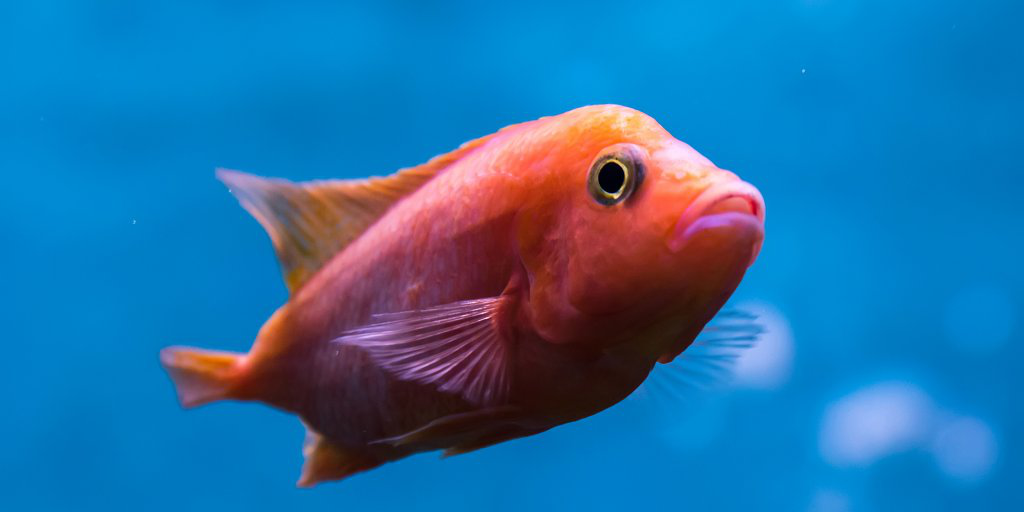

In [34]:
url = 'https://api.time.com/wp-content/uploads/2019/11/fish-with-human-face-tik-tok-video.jpg?quality=85&w=1024&h=512&crop=1'
res = requests.get(url)
img_arr = imageio.imread(BytesIO(res.content))
img_arr=Image.fromarray(img_arr)

img_arr = np.array(img_arr)/255.
gt = np.copy(img_arr)

H,W, _ = img_arr.shape

print(H,W)

#im = Image.fromarray((img_arr*255).astype(np.uint8))
showarray(img_arr)

In [35]:
xx, yy = tf.meshgrid(np.arange(H),np.arange(W), indexing = 'ij')
indices = tf.cast( tf.concat([xx[...,None], yy[...,None]],-1), tf.int32)

w_down = 8
h_down = 8

train_indices = indices[::h_down, ::w_down]
train_rgbs = tf.gather_nd(img_arr,train_indices).numpy()

train_indices /= [H,W]

train_indices = tf.reshape(train_indices, [-1,2])
train_rgbs = tf.reshape(train_rgbs, [-1,3])

print(train_indices.shape)

(8192, 2)


### Look how sparse the supervision signals are!

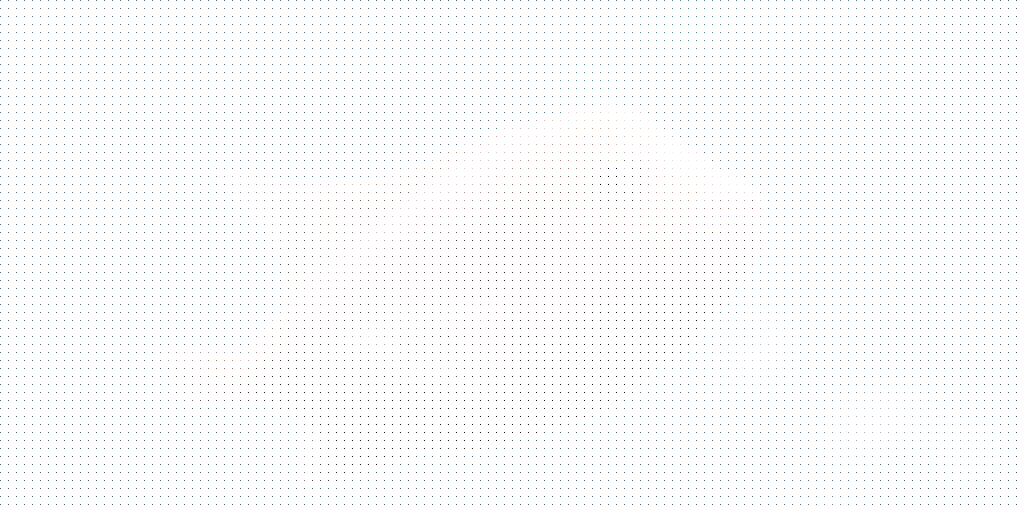

In [4]:
viz_vals = np.zeros((H,W))
viz_vals[::h_down, ::w_down]+=1
viz_vals = np.logical_not(viz_vals.astype(np.bool))
viz_array = np.copy(img_arr)
viz_array[viz_vals] = [1,1,1]

showarray(viz_array)

In [36]:
x=train_indices
#This scale performs better than 5 and 10
scale = 3
input_dims = x.shape[-1]
num_features = 16
B = scale * np.random.normal(size=(input_dims, num_features))
input_encoder = lambda x, B: np.concatenate([ np.sin((2.*np.pi*x) @ B), 
                                                     np.cos((2.*np.pi*x) @ B)], axis=-1)
embedded_train_indices = input_encoder(x, B)

In [5]:
#Make batching object
class batcher_obj:
  def __init__(self, inputs, labels, batch_size = 512):
    self.inputs =  tf.cast(inputs, tf.float32).numpy()
    self.labels = tf.cast(labels, tf.float32).numpy()
    self.index = 0
    self.batch_size = batch_size
  def __next__(self):
    return self.next()
  def next(self):
    if self.index + self.batch_size > self.inputs.shape[0]:
      self.index = self.batch_size
      perm = np.arange(self.inputs.shape[0])
      np.random.shuffle(perm)
      self.inputs = self.inputs[perm]
      self.labels = self.labels[perm]
      return self.inputs[:self.batch_size], self.labels[:self.batch_size]
    else:
      self.index += self.batch_size
      return self.inputs[self.index - self.batch_size: self.index], self.labels[self.index - self.batch_size: self.index]

#Normal inputs
vanilla_relu_batcher = batcher_obj(train_indices, train_rgbs)

#Squish rgb vals to [-1,1]
sin_batcher = batcher_obj(train_indices, train_rgbs*2-1)

#Embed coordinates
embedded_relu_batcher = batcher_obj(embedded_train_indices, train_rgbs)


In [51]:
#necessary to multiply only the non-translated result of dense layer by w_0 as proposed in SIREN
class trainable_sin_layer(tf.keras.layers.Layer):
    def __init__(self, w0 = 10, dim = 256, scalar_weight_trainable = False):
        super(trainable_sin_layer, self).__init__()
        self.dim = dim
        weight_init = tf.constant_initializer(value = w0)
        self.scalar_weight = self.add_weight(shape=(1), initializer = weight_init, trainable=scalar_weight_trainable)

    def build(self, input_shape):
        n = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_shape[-1], self. dim), initializer=tf.random_uniform_initializer(minval=-np.sqrt(6/n), maxval=np.sqrt(6/n))  )
        self.bias = self.add_weight(shape=(1,self. dim), initializer=tf.zeros_initializer())
    def call(self, input):
        return tf.keras.backend.sin(self.scalar_weight * tf.matmul(input, self.kernel) + self.bias)



# Models
We define the models to justify our choice of model with first and last sin activations and intermediate activations relu. Each model is 5 layers with the first four being 256 wide and the last being 3 wide. The networks are not especially wide, but the amount of data is very small, and we see agreement with the theory later on in NTK analysis.

In [78]:
#Vanilla Relu Model (no P.E. and sigmoid output)
input = tf.keras.Input(train_indices.shape[-1])
xx = tf.keras.layers.Dense(256, 'relu')(input)
xx = tf.keras.layers.Dense(256, 'relu')(xx)
xx = tf.keras.layers.Dense(256, 'relu')(xx)
xx = tf.keras.layers.Dense(256, 'relu')(xx)
output = tf.keras.layers.Dense(3, 'sigmoid')(xx)
vanilla_relu_model = tf.keras.Model(input, output)

#Embedded Relu Model (sigmoid output)
input = tf.keras.Input(embedded_train_indices.shape[-1])
xx = tf.keras.layers.Dense(256, 'relu')(input)
xx = tf.keras.layers.Dense(256, 'relu')(xx)
xx = tf.keras.layers.Dense(256, 'relu')(xx)
xx = tf.keras.layers.Dense(256, 'relu')(xx)
output = tf.keras.layers.Dense(3, 'sigmoid')(xx)
embedded_relu_model = tf.keras.Model(input, output)

#SIREN
input = tf.keras.Input(train_indices.shape[-1])
xx = trainable_sin_layer(w0=30, dim=256)(input)
xx = tf.keras.layers.Dense(256, tf.keras.backend.sin, kernel_initializer=tf.random_uniform_initializer(minval=-np.sqrt(6/256), maxval=np.sqrt(6/256)))(xx)
xx = tf.keras.layers.Dense(256, tf.keras.backend.sin, kernel_initializer=tf.random_uniform_initializer(minval=-np.sqrt(6/256), maxval=np.sqrt(6/256)))(xx)
xx = tf.keras.layers.Dense(256, tf.keras.backend.sin, kernel_initializer=tf.random_uniform_initializer(minval=-np.sqrt(6/256), maxval=np.sqrt(6/256)))(xx)
output = tf.keras.layers.Dense(3, kernel_initializer=tf.random_uniform_initializer(minval=-np.sqrt(6/256), maxval=np.sqrt(6/256)))(xx) #no activation
siren_model = tf.keras.Model(input, output)

#Our proposed with sin output
input = tf.keras.Input(train_indices.shape[-1])
xx = tf.keras.layers.Dense(256, kernel_initializer=tf.random_uniform_initializer(minval=-np.sqrt(6/2), maxval=np.sqrt(6/2), seed=None))(input)
xx=tf.keras.backend.sin(10 * xx)
xx = tf.keras.layers.Dense(256, 'relu')(xx)
xx = tf.keras.layers.Dense(256, 'relu')(xx)
xx = tf.keras.layers.Dense(256, 'relu')(xx)
xx = tf.keras.layers.Dense(3, kernel_initializer=tf.random_uniform_initializer(minval=-np.sqrt(6/256), maxval=np.sqrt(6/256)))(xx)
output = tf.keras.backend.sin(xx)
our_model = tf.keras.Model(input, output)

#Our proposed with sigmoid output
input = tf.keras.Input(train_indices.shape[-1])
xx = tf.keras.layers.Dense(256, kernel_initializer=tf.random_uniform_initializer(minval=-np.sqrt(6/2), maxval=np.sqrt(6/2), seed=None))(input)
xx=tf.keras.backend.sin(10 * xx)
xx = tf.keras.layers.Dense(256, 'relu')(xx)
xx = tf.keras.layers.Dense(256, 'relu')(xx)
xx = tf.keras.layers.Dense(256, 'relu')(xx)
output = tf.keras.layers.Dense(3, 'sigmoid')(xx)
our_sigmoid_model = tf.keras.Model(input, output)

#Our proposed with sigmoid output and unweighted bias
input = tf.keras.Input(train_indices.shape[-1])
xx = trainable_sin_layer(w0=10, dim=256)(input)
xx = tf.keras.layers.Dense(256, 'relu')(xx)
xx = tf.keras.layers.Dense(256, 'relu')(xx)
xx = tf.keras.layers.Dense(256, 'relu')(xx)
output = tf.keras.layers.Dense(3, 'sigmoid')(xx)
our_sigmoid_unweighted_model = tf.keras.Model(input, output)


#Our proposed with sin output and normal initialization
input = tf.keras.Input(train_indices.shape[-1])
xx = tf.keras.layers.Dense(256, kernel_initializer = tf.random_normal_initializer())(input)
xx=tf.keras.backend.sin(10 * xx)
xx = tf.keras.layers.Dense(256, 'relu', kernel_initializer = tf.random_normal_initializer())(xx)
xx = tf.keras.layers.Dense(256, 'relu', kernel_initializer = tf.random_normal_initializer())(xx)
xx = tf.keras.layers.Dense(256, 'relu', kernel_initializer = tf.random_normal_initializer())(xx)
xx = tf.keras.layers.Dense(3, kernel_initializer = tf.random_normal_initializer())(xx)
output = tf.keras.backend.sin(xx)
our_normal_model = tf.keras.Model(input, output)



In [8]:
def get_our_model(w_0, output_activation = 'sigmoid'):
  if output_activation is 'sigmoid':
    output_activation = tf.nn.sigmoid
  elif output_activation is 'sin':
    output_activation = tf.keras.backend.sin
  else:
    raise ValueError("unknown activation: ", output_activation)
  input = tf.keras.Input(train_indices.shape[-1])
  xx = tf.keras.layers.Dense(256, kernel_initializer=tf.random_uniform_initializer(minval=-np.sqrt(6/2), maxval=np.sqrt(6/2), seed=None))(input)
  xx=tf.keras.backend.sin(w_0 * xx)
  xx = tf.keras.layers.Dense(256, 'relu')(xx)
  xx = tf.keras.layers.Dense(256, 'relu')(xx)
  xx = tf.keras.layers.Dense(256, 'relu')(xx)
  xx = tf.keras.layers.Dense(3)(xx)
  output = output_activation(xx)
  our_model = tf.keras.Model(input, output)
  return our_model

In [9]:
#Make image tensor given model, may need to be proccessed further based on imp
def make_image(model, H, W, batch_size = 1024, apply_encoding = False, change_range = False, B=B):
  xx, yy = tf.meshgrid(np.arange(H),np.arange(W), indexing = 'ij')
  indices = tf.cast( tf.concat([xx[...,None], yy[...,None]],-1), tf.float32)
  indices /= [H,W]
  indices = tf.cast(tf.reshape(indices, [-1,2]), tf.float32)

  if change_range:
    indices = indices * 2 - 1
  if apply_encoding:
    indices = input_encoder(indices, B)

  outputs = []
  for i in range(0, indices.shape[0], batch_size):
    outputs.append(model(indices[i:i+batch_size]))
  outputs = np.concatenate(outputs,0).reshape((H,W,3))
  return outputs


def train_model(model, batcher, optimizer, num_iters):
  grad_vars = model.trainable_variables
  for i in range(num_iters):
    with tf.GradientTape() as tape:
      inputs, labels = next(batcher)
      outputs = model(inputs)
      loss = tf.reduce_mean((outputs-labels)**2)
    grads = tape.gradient(loss, grad_vars)
    optimizer.apply_gradients(zip(grads,grad_vars))


# Qualitative Results for the architectures
We provide qualitative results for each of the above architectures on the fish image, including quantiative metrics of PSNR and SSIM. 

#### Vanilla ReLU MLP with no P.E.
Here we see the rather poor results of the vanilla ReLU MLP

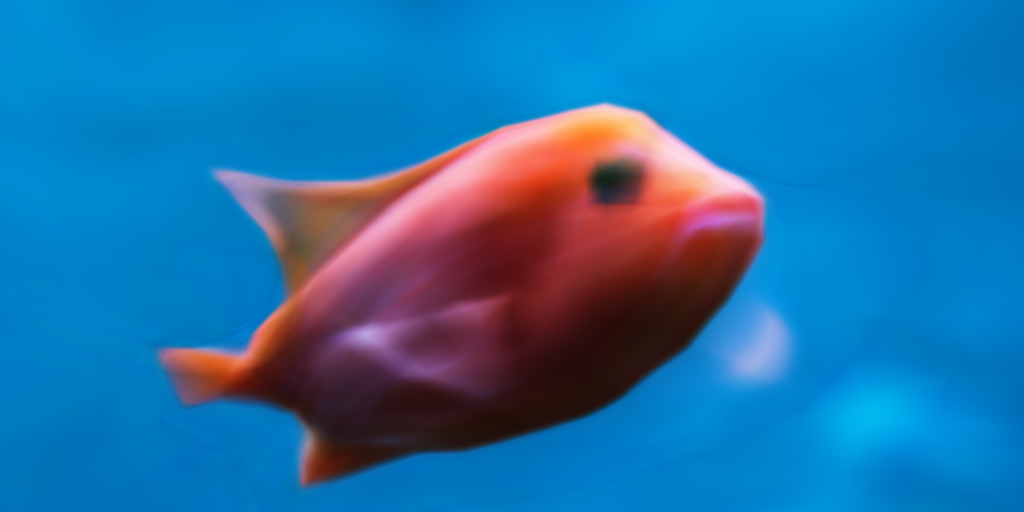

tf.Tensor(26.735876, shape=(), dtype=float32)
tf.Tensor(0.89668816, shape=(), dtype=float32)


In [ ]:
num_iters = 10000
vanilla_relu_optimizer = tf.optimizers.Adam(1e-3)

train_model(vanilla_relu_model, vanilla_relu_batcher, vanilla_relu_optimizer, num_iters)

output = make_image(vanilla_relu_model, H,W)
showarray(output)
print(tf.image.psnr(gt, output, max_val=1.))
print(tf.image.ssim(tf.cast(gt, tf.float32),output, max_val=1.))


### SIREN
Here we test a five-layer SIREN, which achieves a good PSNR, but has many pink artifacts as evidenced by the low SSIM. This is consistent with the idea that SIREN is good at memorizing things as in the paper, but not as good at generalizing. Note we also empirically find that inputs in the range of [0,1] performs significantly better than inputs in the range [-1,1], slight difference from the paper. Interestingly, these pink artifacts will show up again when performing the same task with the NTK.

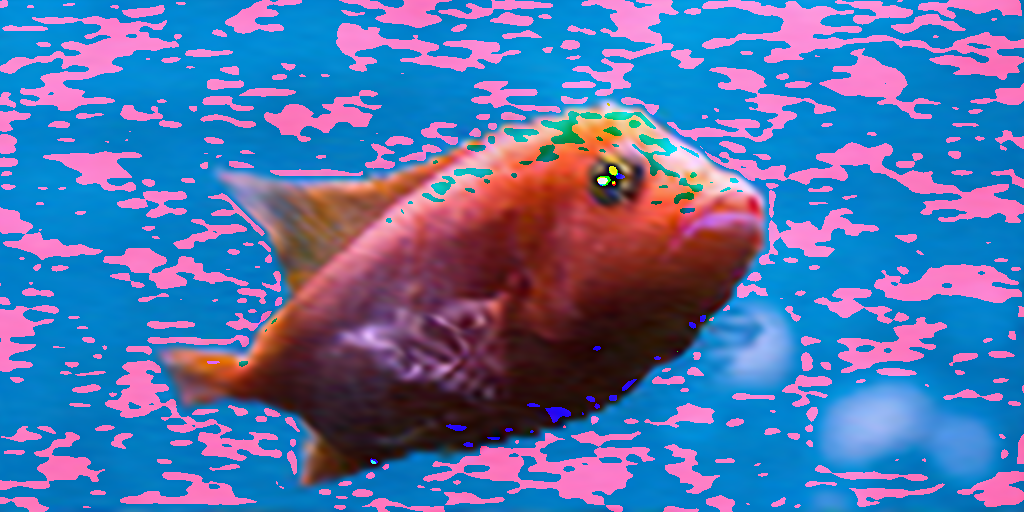

tf.Tensor(29.685173, shape=(), dtype=float32)
tf.Tensor(0.8403078, shape=(), dtype=float32)


In [79]:
num_iters = 10000
vanilla_relu_optimizer = tf.optimizers.Adam(1e-3)

train_model(siren_model, vanilla_relu_batcher, vanilla_relu_optimizer, num_iters)

output = make_image(siren_model, H,W)
showarray(output)
print(tf.image.psnr(gt, output, max_val=1.))
print(tf.image.ssim(tf.cast(gt, tf.float32),output, max_val=1.))

### ReLU MLP with positional encoding
This performs very well, and we have optimized the hyperparameters finding that the scale of 4 performs best

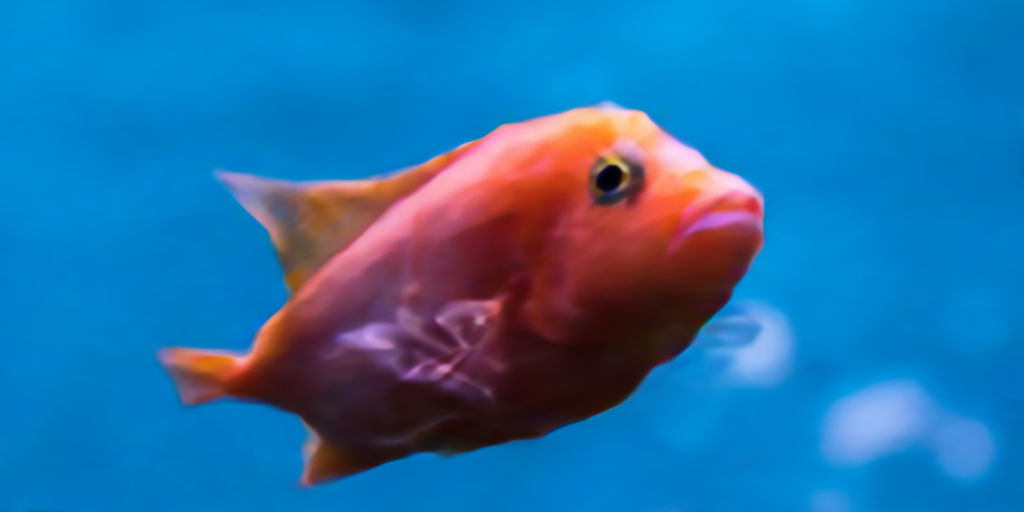

tf.Tensor(30.031658, shape=(), dtype=float32)
tf.Tensor(0.91955376, shape=(), dtype=float32)


In [61]:
num_iters = 10000
vanilla_relu_optimizer = tf.optimizers.Adam(1e-3)

train_model(embedded_relu_model, embedded_relu_batcher, vanilla_relu_optimizer, num_iters)

output = make_image(embedded_relu_model, H,W, apply_encoding=True)
showarray(output)
print(tf.image.psnr(gt, output, max_val=1.))
print(tf.image.ssim(tf.cast(gt, tf.float32),output, max_val=1.))


### SINONE with sigmoid output (ours)
Note that we follow SIREN with uniform initialization of the first layer (and the default glorot uniform from tf for the rest of the layers). This implementation performs very well, but the sigmoid activation is problematic for exact analysis by NTK.

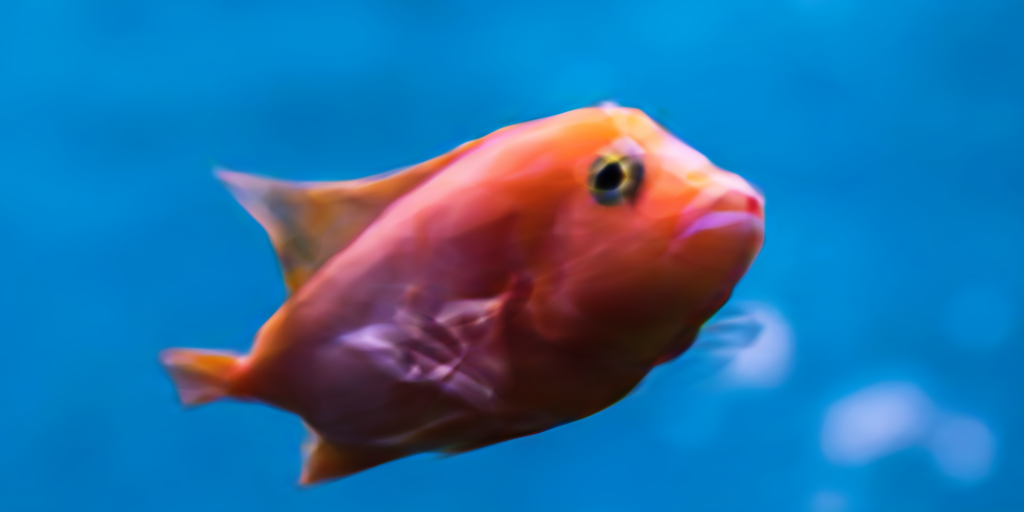

tf.Tensor(30.601763, shape=(), dtype=float32)
tf.Tensor(0.9234821, shape=(), dtype=float32)


In [62]:
num_iters = 10000
vanilla_relu_optimizer = tf.optimizers.Adam(1e-3)

train_model(our_sigmoid_model, vanilla_relu_batcher, vanilla_relu_optimizer, num_iters)

output = make_image(our_sigmoid_model, H,W)
showarray(output)
print(tf.image.psnr(gt, output, max_val=1.))
print(tf.image.ssim(tf.cast(gt, tf.float32),output, max_val=1.))



### SINONE with first layer bias unweighted
In SIREN, the first layer has the form sin(w_0 \* Wx + b), whereas in our formulation, we use sin(w_0*(Wx+b)), because it simplifies computation and theory. In order to justify this, we see if there is a difference in performance in the two approaches. Note also that making this parameter trainable doesn't increase performance, concordonat with the Fourier Features paper.

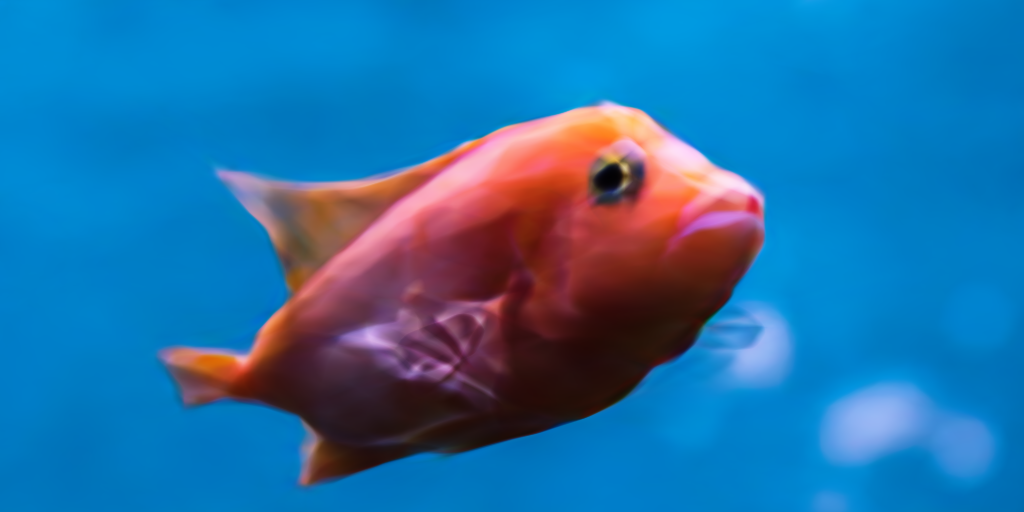

tf.Tensor(30.848043, shape=(), dtype=float32)
tf.Tensor(0.92376477, shape=(), dtype=float32)


In [68]:
num_iters = 10000
vanilla_relu_optimizer = tf.optimizers.Adam(1e-3)

train_model(our_sigmoid_unweighted_model, vanilla_relu_batcher, vanilla_relu_optimizer, num_iters)

output = make_image(our_sigmoid_unweighted_model, H,W)
showarray(output)
print(tf.image.psnr(gt, output, max_val=1.))
print(tf.image.ssim(tf.cast(gt, tf.float32),output, max_val=1.))

### SINONE with Sin output
We squish the outputs to be in [-1,1] so that sin's range corresponds to the range of the RGBs. This performs about the same as sigmoid and ReLU MLP with P.E. 

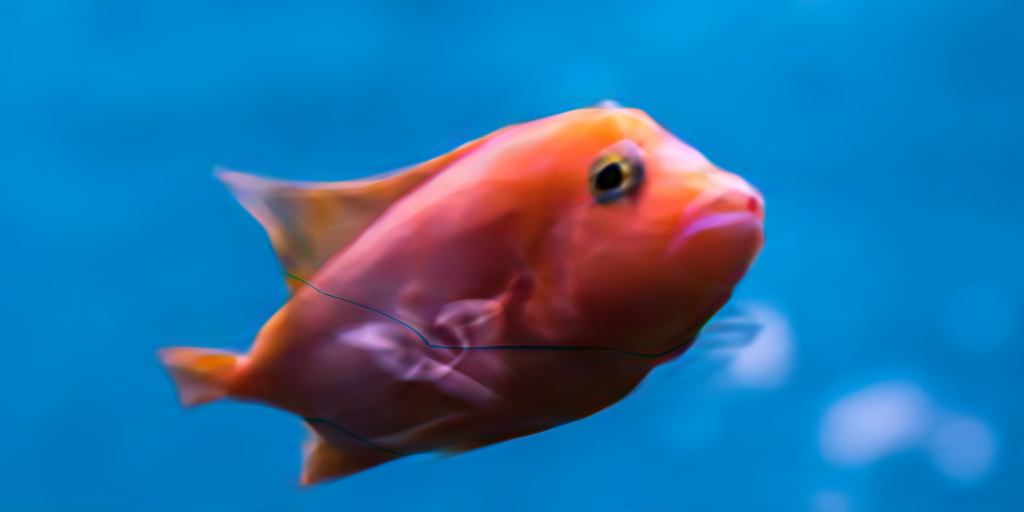

tf.Tensor(30.533792, shape=(), dtype=float32)
tf.Tensor(0.9207387, shape=(), dtype=float32)


In [64]:
num_iters = 10000
vanilla_relu_optimizer = tf.optimizers.Adam(1e-3)

train_model(our_model, sin_batcher, vanilla_relu_optimizer, num_iters)

output = make_image(our_model, H,W)/2+1/2
showarray(output)
print(tf.image.psnr(gt, output, max_val=1.))
print(tf.image.ssim(tf.cast(gt, tf.float32),output, max_val=1.))


### SINONE with normal initializations
Note that during analysis with the NTK, we will look at the models initalized with normal distributions and trained with SGD rather than Adam. To see how this initialization may adversely performance, we notice  worse performance with a normal initialization. 

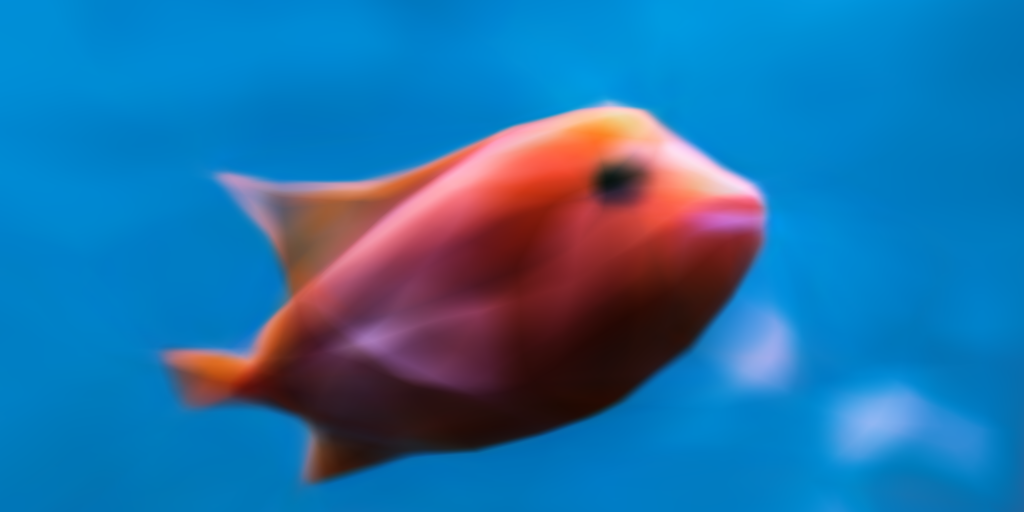

tf.Tensor(27.652895, shape=(), dtype=float32)
tf.Tensor(0.8893864, shape=(), dtype=float32)


In [ ]:
num_iters = 10000
vanilla_relu_optimizer = tf.optimizers.Adam(1e-3)

train_model(our_normal_model, sin_batcher, vanilla_relu_optimizer, num_iters)

output = make_image(our_normal_model, H,W)/2+1/2
showarray(output)
print(tf.image.psnr(gt, output, max_val=1.))
print(tf.image.ssim(tf.cast(gt, tf.float32),output, max_val=1.))



# Comments
| Model                 | PSNR  | SSIM  |
|-----------------------|-------|-------|
| Vanilla ReLU          | 26.74 | 0.897 |
| SIREN                 | 29.68 | 0.840 |
| ReLU with P.E.        | 30.03 | 0.920 |
| Ours with sigmoid     | 30.60 | 0.923 |
|Ours with sigmoid, unweighted bias | **30.84**| **0.924**|
| Ours with sin         | 30.53 | 0.921 |
| Ours with normal init | 27.65 | 0.889 |

As expected, a vanilla ReLU MLP doesn't perform as well as the other methods. Interestingly, SIREN achieves a very high PSNR, but a low SSIM, pointing to its ability to memorize pixels very well as it does in the paper, but perhaps not to generalize as well. The ReLU with P.E. along with our proposed methods with uniform initalizations perform about the same, but our proposed method doesn't require preprocessing of the data and a larger input feature size. Interestingly, the uniform initialization is integral to good performance; we can see the sharp details are completely lost with normal initialization pointing. This may be because, as suggested by (Sitzmann et al., 2020), the uniform distribution induces the output of the sin layer to follow a normal distribution, allowing better convergence properties. 

# Analysis of the Proposed Method with the NTK

We move on to work with the Neural Tangents Library to elucidate some key ideas about the proposed method. We visualize the result along with the induced kernel. Interestingly, all methods that incorporate sin in some manner have a strong diagonal in contrast to the kernel of the vanilla ReLU MLP.

In [7]:
!pip install -q git+https://www.github.com/google/neural-tangents
import jax.numpy as np
import numpy as onp

from jax import random
from jax.experimental import optimizers
from jax.api import jit, grad, vmap
from jax.config import config ; config.update('jax_enable_x64', True)

import functools
import neural_tangents as nt
from neural_tangents import stax

train_y_sin = (train_rgbs*2-1).numpy()
train_y = train_rgbs.numpy()

train_x = train_indices.numpy()
embedded_train_x = input_encoder(train_x, B)

def batchify_ntk(kernel_fn, predict_fn, fn_at_init, fx_train_0, train_x, test_x, t=None, batch_size = 10000):
  ret_list = []
  for i in range(0, test_x.shape[0], batch_size):
       fx_test_0 = fn_at_init(test_x)
       k_test_train = kernel_fn(test_x[i:i+batch_size], train_x, 'ntk')
       _, test_prediction = predict_fn(t=t, fx_train_0=fx_train_0, fx_test_0=fx_test_0[i:i+batch_size], k_test_train=k_test_train)
       ret_list.append(test_prediction)
  return np.concatenate(ret_list, 0)


In [8]:
our_network = stax.serial(
    stax.Dense(512,W_std=np.sqrt(2.), b_std=0.1,parameterization='standard'),
    stax.DotGeneral(rhs=10),
    stax.Sin(),
    stax.Dense(512, W_std=np.sqrt(2.), b_std=0.1,parameterization='standard'),
    stax.Relu(),
    stax.Dense(512, W_std=np.sqrt(2.), b_std=0.1,parameterization='standard'),
    stax.Relu(),
    stax.Dense(512, W_std=np.sqrt(2.), b_std=0.1,parameterization='standard'),
    stax.Relu(),
    stax.Dense(3, W_std=np.sqrt(2.), b_std=0.1,parameterization='standard'),
    stax.Sin(),
)
#Not exactly SIREN because of the initialization and the muultiplication of the bias by w_0
siren_network = stax.serial(
    stax.Dense(512,W_std=np.sqrt(2.), b_std=0.1,parameterization='standard'),
    stax.DotGeneral(rhs=30),
    stax.Sin(),
    stax.Dense(512, W_std=np.sqrt(2.), b_std=0.1,parameterization='standard'),
    stax.Sin(),
    stax.Dense(512, W_std=np.sqrt(2.), b_std=0.1,parameterization='standard'),
    stax.Sin(),
    stax.Dense(512, W_std=np.sqrt(2.), b_std=0.1,parameterization='standard'),
    stax.Sin(),
    stax.Dense(3, W_std=np.sqrt(2.), b_std=0.1,parameterization='standard'),
    #stax.Sin()
)

our_sigmoid_network = stax.serial(
    stax.Dense(512,W_std=np.sqrt(2.), b_std=0.1,parameterization='standard'),
    stax.DotGeneral(rhs=10),
    stax.Sin(),
    stax.Dense(512, W_std=np.sqrt(2.), b_std=0.1,parameterization='standard'),
    stax.Relu(),
    stax.Dense(512, W_std=np.sqrt(2.), b_std=0.1,parameterization='standard'),
    stax.Relu(),
    stax.Dense(512, W_std=np.sqrt(2.), b_std=0.1,parameterization='standard'),
    stax.Relu(),
    stax.Dense(3, W_std=np.sqrt(2.), b_std=0.1,parameterization='standard'),
    stax.Sigmoid_like(),
)

relu_network = stax.serial(
    stax.Dense(512, W_std=np.sqrt(2.), b_std=0.1, parameterization='standard'),
    stax.Relu(),
    stax.Dense(512, W_std=np.sqrt(2.), b_std=0.1, parameterization='standard'),
    stax.Relu(),
    stax.Dense(512, W_std=np.sqrt(2.), b_std=0.1, parameterization='standard'),
    stax.Relu(),
    stax.Dense(512, W_std=np.sqrt(2.), b_std=0.1, parameterization='standard'),
    stax.Relu(),
    stax.Dense(3, W_std=np.sqrt(2.), b_std=0.1, parameterization='standard'),
    stax.Sigmoid_like()
)




In [9]:
def get_predictions(network, train_x, test_x, train_y, t = None):
  init_fn, apply_fn, kernel_fn = network
  kernel_fn = jit(kernel_fn, static_argnums=(2,))
  key = random.PRNGKey(10)
  _, params = init_fn(key, (-1,train_x.shape[-1]))

  k_train_train = kernel_fn(train_x, train_x,'ntk')
  predict_fn = jit(nt.predict.gradient_descent_mse(k_train_train, train_y))
  fx_train_0 = apply_fn(params, train_x)

  fn_at_init = jit(lambda test_vals : apply_fn(params, test_x))
  return batchify_ntk(kernel_fn, predict_fn, fn_at_init, fx_train_0, train_x, test_x, t), k_train_train

def make_image_ntk(network, train_x, train_y, apply_encoding=False, change_range = False, change_domain = False, t = None):
  xx, yy = tf.meshgrid(np.arange(H),np.arange(W), indexing = 'ij')
  indices = tf.cast( tf.concat([xx[...,None], yy[...,None]],-1), tf.float64)
  indices /= [H,W]
  test_indices = tf.cast(tf.reshape(indices, [-1,2]), tf.float64).numpy()
  if apply_encoding:
    test_indices = input_encoder(test_indices, B)
  if change_domain:
    test_indices = test_indices*2-1
  preds, k_train_train = get_predictions(network, train_x, test_indices, train_y, t)
  if change_range:
    preds = preds/2+1/2
  return onp.asarray(np.reshape( (preds), (512,1024,3))), k_train_train

# Qualitative Results in Theory and NTK Visualizations

### Basic ReLU NTK

Nan values? False
tf.Tensor(27.84613, shape=(), dtype=float32)
tf.Tensor(0.8863593, shape=(), dtype=float32)


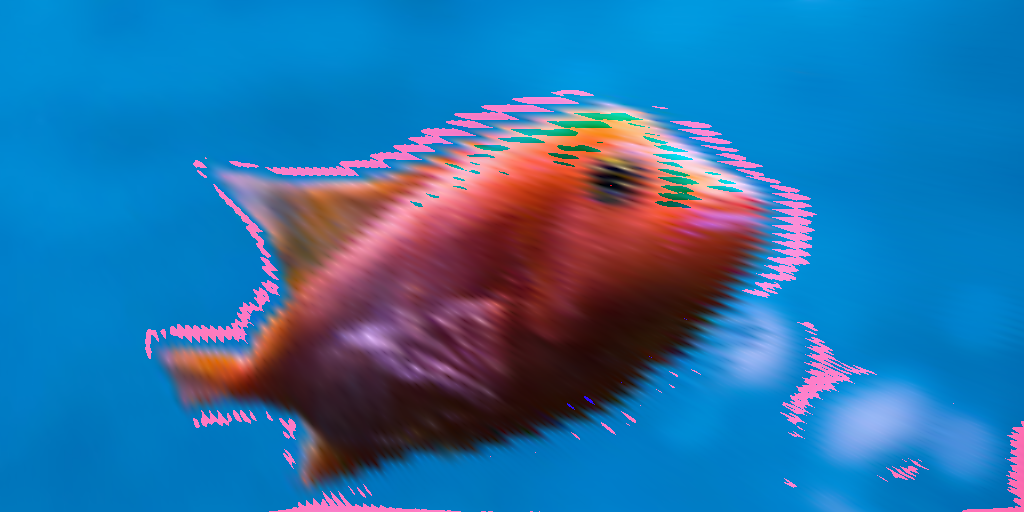

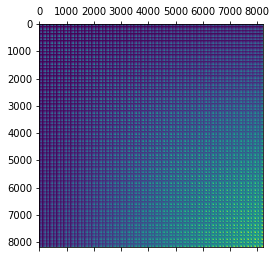

In [92]:
img_pred, k_train_train = make_image_ntk(relu_network, train_x, train_y)
print("Nan values?", np.any(np.isnan(img_pred)))
print(tf.image.psnr(img_pred, gt, max_val=1))
print(tf.image.ssim(img_pred.astype(np.float32), gt.astype(np.float32), max_val=1))
showarray(img_pred)
plt.matshow(k_train_train)

## SIREN
Note the comparatively weaker diagonal

Nan values? False
tf.Tensor(24.67101, shape=(), dtype=float32)
tf.Tensor(0.62503463, shape=(), dtype=float32)


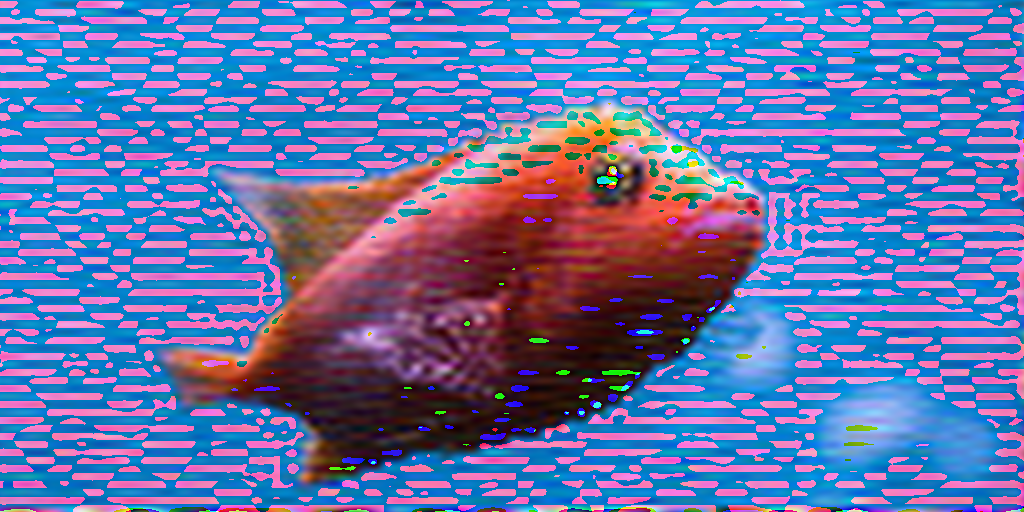

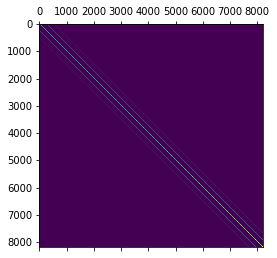

In [91]:
img_pred, k_train_train = make_image_ntk(siren_network, train_x, train_y)
print("Nan values?", np.any(np.isnan(img_pred)))
print(tf.image.psnr(img_pred, gt, max_val=1))
print(tf.image.ssim(img_pred.astype(np.float32), gt.astype(np.float32), max_val=1))
showarray(img_pred)
plt.matshow(k_train_train)

### ReLU NTK with P.E.

Nan values? False
tf.Tensor(30.152489, shape=(), dtype=float32)
tf.Tensor(0.88211226, shape=(), dtype=float32)


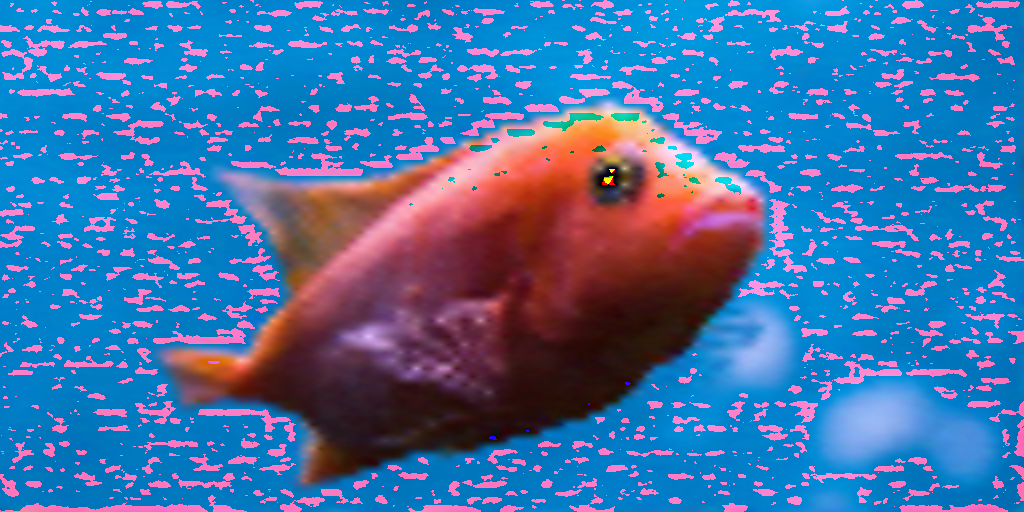

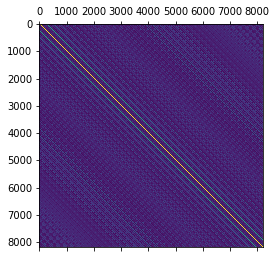

In [94]:
img_pred, k_train_train = make_image_ntk(relu_network, embedded_train_x, train_y, apply_encoding = True)
print("Nan values?", np.any(np.isnan(img_pred)))
print(tf.image.psnr(img_pred, gt, max_val=1))
print(tf.image.ssim(img_pred.astype(np.float32), gt.astype(np.float32), max_val=1))
showarray(img_pred)
plt.matshow(k_train_train)

### SINONE with Sin activation

Nan values? False
tf.Tensor(30.200855, shape=(), dtype=float32)
tf.Tensor(0.90324265, shape=(), dtype=float32)


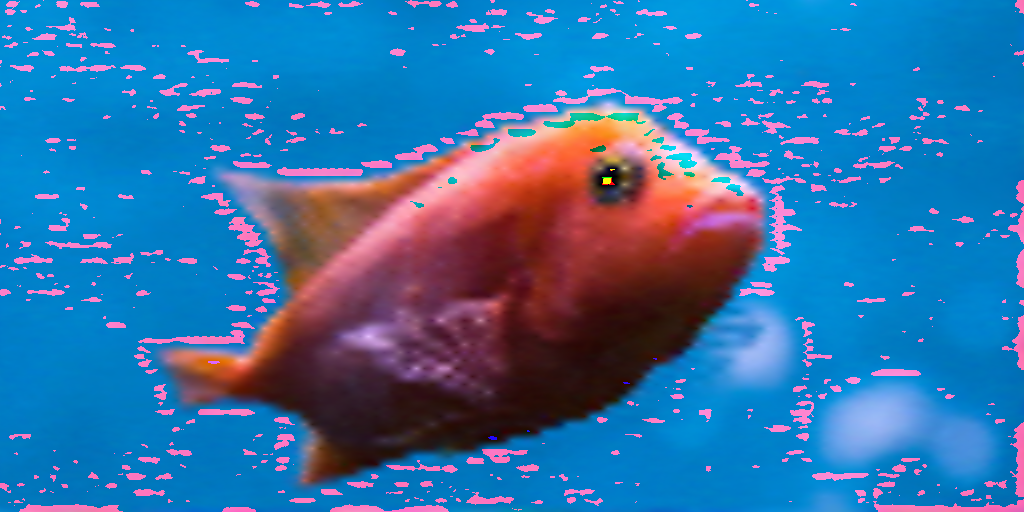

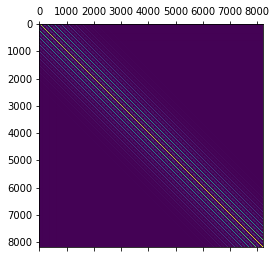

In [95]:
img_pred, k_train_train = make_image_ntk(our_network, train_x, train_y_sin, change_range = True)
print("Nan values?", np.any(np.isnan(img_pred)))
print(tf.image.psnr(img_pred, gt, max_val=1))
print(tf.image.ssim(img_pred.astype(np.float32), gt.astype(np.float32), max_val=1))
showarray(img_pred)
plt.matshow(k_train_train)

### SINONE with Sigmoid(-like) Activation

Nan values? False
tf.Tensor(30.288235, shape=(), dtype=float32)
tf.Tensor(0.9122434, shape=(), dtype=float32)


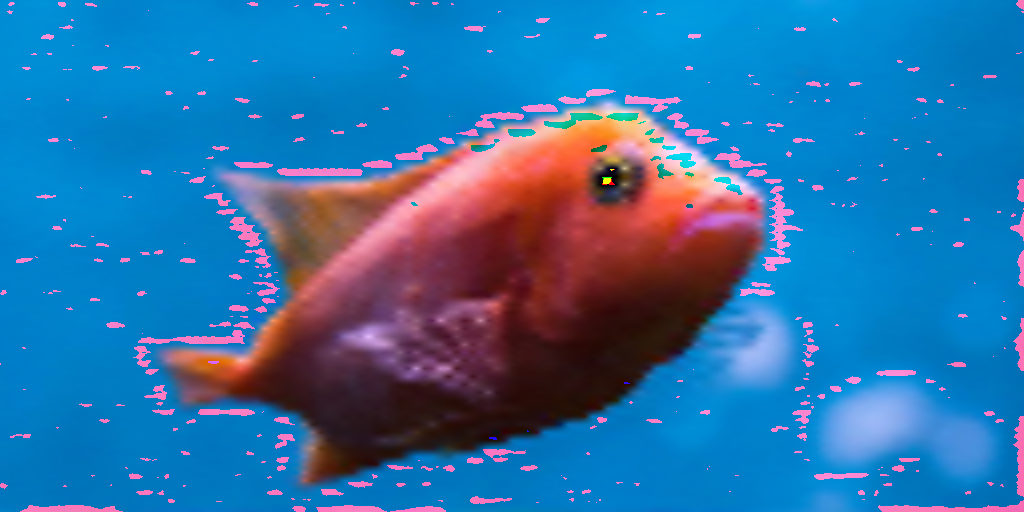

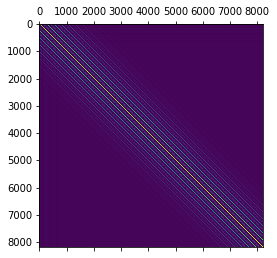

In [96]:
img_pred, k_train_train = make_image_ntk(our_sigmoid_network, train_x, train_y)
print("Nan values?", np.any(np.isnan(img_pred)))
print(tf.image.psnr(img_pred, gt, max_val=1))
print(tf.image.ssim(img_pred.astype(np.float32), gt.astype(np.float32), max_val=1))
showarray(img_pred)
plt.matshow(k_train_train)

# Theoretical Results

| NTK Model                 | PSNR  | SSIM  |
|-----------------------|-------|-------|
| Vanilla ReLU          | 27.84 | 0.886 |
| SIREN                 | 24.67 | 0.625 |
| ReLU with P.E.        | 30.15 | 0.882 |
| SINONE (sin)     | 30.20 | 0.903 |
| SINONE (sigmoid)         | **30.29** | **0.912** |

We note that the SIREN diagonal is comparatively weaker than the ReLU with PE and our SINONE architectures, while the vanilla ReLU has an even weaker diagonal.


# On the Scale Parameter
Because the ReLU with P.E., and our model outperform SIREN and a vanilla MLP both empirically and in theory, we focus on this encoding now. We perform experiments to see if the effect of the scale parameter is the same. Note that when we say scale parameter, we mean that if the first layer output of SINONE is sin(w_0(Wx+b)), then we ask questions about what happens when we vary w_0. The fourier features paper calls the standard deviation of the distribution from which they draw the b_j the scale. Note that it fulfills a very similar purpose, e.g., P.E.(x) = [cos(2\*pi\*b_1\*x),sin(2\*pi\*b_1\*x)] if x was a scalar and there were only 2 features.

In [10]:
def get_our_network(w0 = 10, output_act = stax.Sigmoid_like() ):
    net = stax.serial(
      stax.Dense(512,W_std=np.sqrt(2.), b_std=0.1,parameterization='standard'),
      stax.DotGeneral(rhs=w0),
      stax.Sin(),
      stax.Dense(512, W_std=np.sqrt(2.), b_std=0.1,parameterization='standard'),
      stax.Relu(),
      stax.Dense(512, W_std=np.sqrt(2.), b_std=0.1,parameterization='standard'),
      stax.Relu(),
      stax.Dense(512, W_std=np.sqrt(2.), b_std=0.1,parameterization='standard'),
      stax.Relu(),
      stax.Dense(3, W_std=np.sqrt(2.), b_std=0.1,parameterization='standard'),
      output_act,
    )
    return net

def get_empirical_relu_model():
  input = tf.keras.Input(embedded_train_indices.shape[-1])
  xx = tf.keras.layers.Dense(256, 'relu')(input)
  xx = tf.keras.layers.Dense(256, 'relu')(xx)
  xx = tf.keras.layers.Dense(256, 'relu')(xx)
  xx = tf.keras.layers.Dense(256, 'relu')(xx)
  output = tf.keras.layers.Dense(3, 'sigmoid')(xx)
  return tf.keras.Model(input, output)

In [10]:
w0_list = np.logspace(1,np.log2(100),base=2,num=20)
psnr_list = []
ssim_list = []
for w0 in w0_list:
  model = get_our_model(w0)
  optimizer = tf.optimizers.Adam(1e-3)
  train_model(model, vanilla_relu_batcher, optimizer, 10000)
  output = make_image(model, H,W)
  psnr_list.append(tf.image.psnr(gt, output, max_val=1.))
  ssim_list.append(tf.image.ssim(tf.cast(gt, tf.float32),output, max_val=1.))

In [21]:
w0_list = np.logspace(1,np.log2(100),base=2,num=20)
ntk_psnr_list = []
ntk_ssim_list = []
for w0 in w0_list:
  img_pred, _ = make_image_ntk(get_our_network(w0), train_x, train_y)
  ntk_psnr_list.append( tf.image.psnr(img_pred, gt, max_val=1) )
  ntk_ssim_list.append( tf.image.ssim(img_pred.astype(np.float32), gt.astype(np.float32), max_val=1) )

print(ntk_psnr_list)
print(ntk_ssim_list)

[<tf.Tensor: shape=(), dtype=float32, numpy=30.211098>, <tf.Tensor: shape=(), dtype=float32, numpy=30.290918>, <tf.Tensor: shape=(), dtype=float32, numpy=30.314215>, <tf.Tensor: shape=(), dtype=float32, numpy=30.316183>, <tf.Tensor: shape=(), dtype=float32, numpy=30.315748>, <tf.Tensor: shape=(), dtype=float32, numpy=30.311481>, <tf.Tensor: shape=(), dtype=float32, numpy=30.309717>, <tf.Tensor: shape=(), dtype=float32, numpy=30.302898>, <tf.Tensor: shape=(), dtype=float32, numpy=30.288551>, <tf.Tensor: shape=(), dtype=float32, numpy=30.259136>, <tf.Tensor: shape=(), dtype=float32, numpy=30.215742>, <tf.Tensor: shape=(), dtype=float32, numpy=30.1294>, <tf.Tensor: shape=(), dtype=float32, numpy=29.966759>, <tf.Tensor: shape=(), dtype=float32, numpy=29.659037>, <tf.Tensor: shape=(), dtype=float32, numpy=29.135517>, <tf.Tensor: shape=(), dtype=float32, numpy=28.251657>, <tf.Tensor: shape=(), dtype=float32, numpy=27.066324>, <tf.Tensor: shape=(), dtype=float32, numpy=25.514315>, <tf.Tensor:

In [12]:
normal_features = onp.random.normal(size=(input_dims, num_features))
B = scale * normal_features

input_encoder = lambda x, B: onp.concatenate([ np.sin((2.*np.pi*x) @ B), 
                                                     np.cos((2.*np.pi*x) @ B)], axis=-1)

In [15]:
w0_list = np.logspace(1,np.log2(100),base=2,num=20)/ (2 * np.pi) #divide by 2*pi to compensate for 2*pi in original fourier features
embedded_psnr_list = []
embedded_ssim_list = []
for w0 in w0_list:
  model = get_empirical_relu_model()
  B = w0 * normal_features
  optimizer = tf.optimizers.Adam(1e-3)
  batcher = batcher_obj(input_encoder(train_x, B), train_rgbs)
  train_model(model, batcher, optimizer, 10000)
  output = make_image(model, H,W, apply_encoding=True, B=B)
  embedded_psnr_list.append(tf.image.psnr(gt, output, max_val=1.))
  embedded_ssim_list.append(tf.image.ssim(tf.cast(gt, tf.float32),output, max_val=1.))

In [22]:
w0_list = np.logspace(1,np.log2(100),base=2,num=20)/ (2 * np.pi) #divide by 2*pi to compensate for 2*pi in original fourier features

embedded_ntk_psnr_list = []
embedded_ntk_ssim_list = []

for w0 in w0_list:
  B = w0 * normal_features
  img_pred, k_train_train = make_image_ntk(relu_network, input_encoder(train_x, B), train_y, apply_encoding = True)
  embedded_ntk_psnr_list.append( tf.image.psnr(img_pred, gt, max_val=1) )
  embedded_ntk_ssim_list.append( tf.image.ssim(img_pred.astype(np.float32), gt.astype(np.float32), max_val=1) )



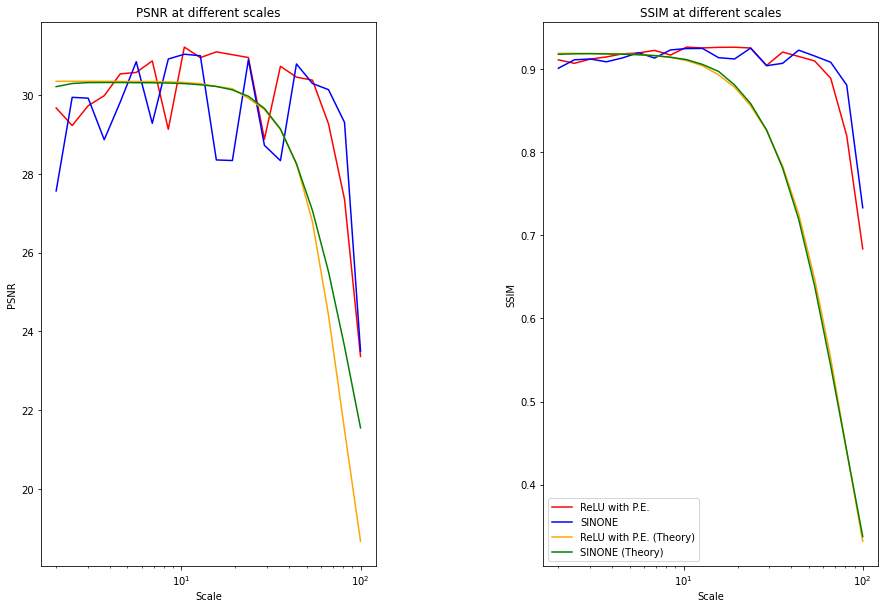

In [26]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(15)
ax[0].set_title("PSNR at different scales")
ax[0].set_ylabel("PSNR")
ax[0].set_xlabel("Scale")
fig1=ax[0].plot(w0_list * 2*onp.pi, embedded_psnr_list, 'r', w0_list * 2*onp.pi, psnr_list, 'b',w0_list * 2*onp.pi, embedded_ntk_psnr_list, 'orange', w0_list * 2*onp.pi,ntk_psnr_list, 'g')
#ax[0].legend(["ReLU with P.E.", "SINONE", "ReLU with P.E. (Theory)", "SINONE (Theory)"])

ax[1].set_title("SSIM at different scales")
ax[1].set_ylabel("SSIM")
ax[1].set_xlabel("Scale")
fig1=ax[1].plot(w0_list * 2*onp.pi, embedded_ssim_list, 'r', w0_list * 2*onp.pi, ssim_list, 'b',w0_list * 2*onp.pi, embedded_ntk_ssim_list, 'orange', w0_list * 2*onp.pi,ntk_ssim_list, 'g')
ax[1].legend(["ReLU with P.E.", "SINONE", "ReLU with P.E. (Theory)", "SINONE (Theory)"])
ax[0].set_xscale('log')
ax[1].set_xscale('log')

fig.subplots_adjust(wspace=.5, hspace=.5)

# Analysis
Very interestingly, our proposed SINONE has very similar convergence properties when varying the scale parameter as the positional embedding proposed in (Tancik et al. 2020), indicating its ability to be tuned as well. However, it requires no preprocessing of the data!

# Investigation of Learned Functions in Theory
Let's consider a 1d horizontal slice of the image, and only the red channel of the image there. We can see how the learned functions differ from the ground truth on this interval. From below, the Vanilla ReLU clearly has large oscillations away from the ground truth indicating an inability to fit the signal. In contrast, both the ReLU with P.E., and our method smoothly fir the data, learning almost the same solution!

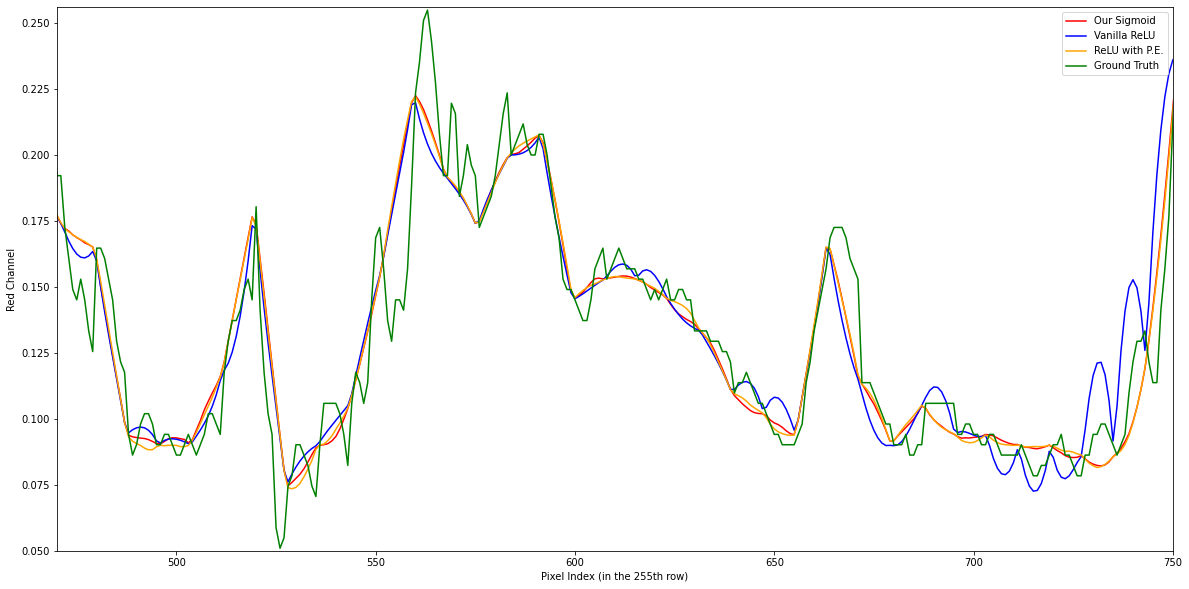

In [32]:
import pylab
# Coordinates along diagonal line in center of image
num_pts = 1024
linear_pts = np.concatenate([ np.array([256]*num_pts)[...,None], np.linspace(0,1024, num_pts)[...,None]], -1)/np.array([H,W])


B = 10 / (onp.pi *2 ) * onp.random.normal(size=(input_dims, num_features))
embedded_train_x = input_encoder(train_x, B=B)

predictions = [get_predictions(our_sigmoid_network, train_x, linear_pts, train_y), 
               get_predictions(relu_network, train_x, linear_pts, train_y),
               get_predictions(relu_network, embedded_train_x, input_encoder(linear_pts, B=B), train_y)]



colors = ['r', 'b', 'orange']
plt.figure(figsize=(20,10))

for pred, color in zip(predictions, colors):
  plt.plot(np.arange(num_pts),pred[0][...,2], color)

plt.plot(np.arange(num_pts),img_arr[256][...,2],'g')
plt.legend(["Our Sigmoid", "Vanilla ReLU", "ReLU with P.E.", "Ground Truth"])
pylab.xlim([470,750])
pylab.ylim([0.05,0.256])
pylab.xlabel("Pixel Index (in the 255th row)");
pylab.ylabel("Red Channel");

# Conclusion
We have shown that a single sin activation at the beginning of a ReLU MLP with final activation of sigmoid or sin can perform at the same level as the positional encoding proposed by Tancik et al. given a suitable choice of hyperparameter scale. Given this correspondence, further theoretical analysis is warranted on how the induced NTK changes as this hyperparameter changes. Moreover, on tasks besides image regression, this simple architecture should be tested. Interesting further tests might inlclude incorporation into occupancy fields and NeRF. 